In [21]:
print("Importing all appropriate libs")
import os,sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.spatial
import cv2
import torch
import matplotlib.pyplot as plt 
import torchvision
import torchsummary
import torch.nn.functional as F
print('torch version:',torch.__version__)
print('numpy version:', np.__version__)
print("torchvision version", torchvision.__version__)

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp



#see: https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#make sure external module get reloaded
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

Importing all appropriate libs
torch version: 1.9.1+cu102
numpy version: 1.18.5
torchvision version 0.10.1+cu102
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## People counting on  Mall dataset
- dset link: http://personal.ie.cuhk.edu.hk/~ccloy/downloads_mall_dataset.html

In [43]:
dataset_dir = 'E:/DS PROJECTS/crowd counting 2/mall_dataset'


In [23]:
import glob
import os

In [24]:
image_paths = glob.glob(os.path.join(dataset_dir, 'frames', 'seq_*.jpg'))
print("len", len(image_paths))

len 2000


In [25]:
image_paths.sort()
image_paths[:3]

['E:\\DS PROJECTS\\crowd counting 2\\mall_dataset\\frames\\seq_000001.jpg',
 'E:\\DS PROJECTS\\crowd counting 2\\mall_dataset\\frames\\seq_000002.jpg',
 'E:\\DS PROJECTS\\crowd counting 2\\mall_dataset\\frames\\seq_000003.jpg']

## Examine groundtruth labels

In [26]:
import scipy.io

sample_number = 500 
#ground truth labels is stored in matlab struct files
gt_data = scipy.io.loadmat(os.path.join(dataset_dir, 'mall_gt.mat'))

In [27]:
#sanity check
x_test = gt_data['frame'][0,sample_number][0][0][0]# stored in x,y format of numpy array
x_test.shape

(26, 2)

In [28]:
im_test = cv2.imread(image_paths[sample_number])
im_test.shape

(480, 640, 3)

In [29]:
gt_test = np.zeros(im_test.shape[:2])
gt_test.shape

(480, 640)

In [30]:
mask = x_test.astype(int)

In [31]:
gt_test[mask[:,  1], mask[:,  0]] = 1

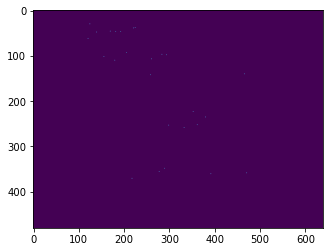

In [32]:
plt.imshow(gt_test)

In [33]:
gt_test.sum()

26.0

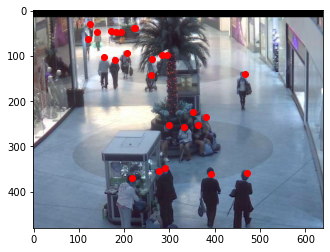

In [34]:
plt.imshow(im_test)
plt.scatter(mask[:,  0], mask[:,  1], c='r')#x, y

## Get dset mean and std

- Last updated (5/12/19)

```
(array([0.53610113, 0.47058904, 0.43273771]),
 array([0.2187217 , 0.21788203, 0.20973989]))
```

In [35]:
def get_mean_std(img_paths, print_freq=20 ) :
    count = 0;
    val_max_img = 255.0;
    mean = np.array([0.] * 3);
    std = np.array([0.] * 3);
    for fname in sorted(img_paths) :
        count += 1;
        im = cv2.imread(fname, cv2.IMREAD_UNCHANGED);
        mean += im.mean(axis=(0,1))/val_max_img;
        std += im.std(axis=(0,1))/val_max_img;
        if (count%print_freq) == 0:
            print ("Done processing image = {}".format(count));

    mean /= count;
    std /= count;

    # swap R and B channel values
    tmp = mean[0];
    mean[0] = mean[2];
    mean[2] = tmp;
    tmp = std[0];
    std[0] = std[2];
    std[2] = tmp;

    return mean, std;

In [36]:
get_mean_std(image_paths[:200])

Done processing image = 20
Done processing image = 40
Done processing image = 60
Done processing image = 80
Done processing image = 100
Done processing image = 120
Done processing image = 140
Done processing image = 160
Done processing image = 180
Done processing image = 200


(array([0.53610113, 0.47058904, 0.43273771]),
 array([0.2187217 , 0.21788203, 0.20973989]))

## Generate Gaussian Activation Map

In [37]:
from scipy import ndimage
#borrowed from #this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    #thanks to: https://gist.github.com/iamtekeste/3cdfd0366ebfd2c0d805
    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 1000
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
#     print ('done.')
    return density

In [38]:
#sanity check
test_gam = gaussian_filter_density(gt_test)

Text(0.5, 1.0, 'Gaussian map')

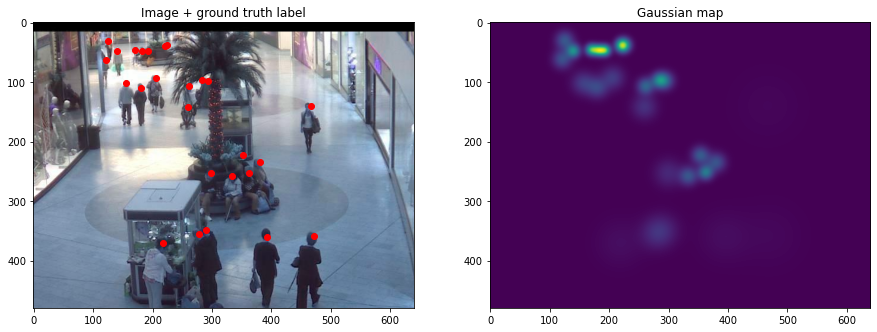

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
axs[0].imshow(im_test)
axs[0].scatter(mask[:,  0], mask[:,  1], c='r')
axs[0].set_title("Image + ground truth label")

axs[1].imshow(test_gam)
axs[1].set_title("Gaussian map")


In [40]:
print("Groudth truth count", gt_test.sum())
print("Gaussian map estimate count", test_gam.sum())

Groudth truth count 26.0
Gaussian map estimate count 25.997278


In [62]:
import pickle

In [64]:
for i in range(200):
    groundtruth_label = gt_data['frame'][0,i][0][0][0].astype(int)
    gt_map = np.zeros(im_test.shape[:2])
    gt_map[groundtruth_label[:,  1], groundtruth_label[:,  0]] = 1
    
    gam_map = gaussian_filter_density(gt_map)
    file_name = os.path.join(dataset_dir, 'gams', 
                             'gam_'+str(i+1).zfill(6)+'.pkl')
    with open(file_name, 'wb') as f:
        pickle.dump(gam_map, f)
    if (i % 10) ==  0:
        print("Done processing", i)
    np.save(file_name, gam_map)

E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000001.pkl
Done processing 0
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000002.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000003.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000004.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000005.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000006.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000007.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000008.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000009.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000010.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000011.pkl
Done processing 10
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000012.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000013.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000014.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam

E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000124.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000125.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000126.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000127.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000128.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000129.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000130.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000131.pkl
Done processing 130
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000132.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000133.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000134.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000135.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000136.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000137.pkl
E:/DS PROJECTS/crowd counting 2/mall_dataset\gams\gam_000138.pkl
E:/DS

## Make test batch

In [65]:
for i in range(400, 450):
    groundtruth_label = gt_data['frame'][0,i][0][0][0].astype(int)
    gt_map = np.zeros(im_test.shape[:2])
    gt_map[groundtruth_label[:,  1], groundtruth_label[:,  0]] = 1
    
    gam_map = gaussian_filter_density(gt_map)
    file_name = os.path.join(dataset_dir, 'gams', 
                             'gam_'+str(i+1).zfill(6)+'.pkl')
    with open(file_name, 'wb') as f:
        pickle.dump(gam_map, f)
    if (i % 10) ==  0:
        print("Done processing", i)
    np.save(file_name, gam_map)

Done processing 400
Done processing 410
Done processing 420
Done processing 430
Done processing 440


### load a test gam images for sanity check

In [67]:
with open(os.path.join(dataset_dir, 'gams', 'gam_000001.pkl'), 'rb') as f:
    test_gam_np = pickle.load(f)

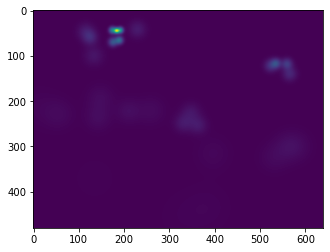

In [68]:
plt.imshow(test_gam_np)

In [69]:
gam_paths = glob.glob(os.path.join(dataset_dir, 'gams', 'gam_*.pkl'))
print("len", len(gam_paths))

len 250


In [70]:
gam_paths.sort()
gam_paths[:3]

['E:/DS PROJECTS/crowd counting 2/mall_dataset\\gams\\gam_000001.pkl',
 'E:/DS PROJECTS/crowd counting 2/mall_dataset\\gams\\gam_000002.pkl',
 'E:/DS PROJECTS/crowd counting 2/mall_dataset\\gams\\gam_000003.pkl']

In [71]:
mall_dataset_meta = {
    'meta' : "Labels is stored in x, y order",
    'images' : image_paths[:200],
    'gams' : gam_paths[:200], 
    'labels' : [gt_data['frame'][0,i][0][0][0].astype(int).tolist() for i in range(200)]
}

In [72]:
mall_dataset_test_meta = {
    'meta' : "Labels is stored in x, y order",
    'images' : image_paths[400:450],
    'gams' : gam_paths[-50:], 
    'labels' : [gt_data['frame'][0,i][0][0][0].astype(int).tolist() for i in range(400,450)]
}

In [73]:
len(mall_dataset_test_meta['labels'][0])

48

## Save in a file. (Do Once)


In [74]:
import json

In [75]:
##Run Once only
with open(os.path.join(dataset_dir, 'meta.json'), 'w') as file:
    json.dump(mall_dataset_meta, file, indent=4)

In [76]:
#save test
with open(os.path.join(dataset_dir, 'meta_test.json'), 'w') as file:
    json.dump(mall_dataset_test_meta, file, indent=4)